# Basic notebook for benchmarking tribus results

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from os import listdir
from os.path import isfile, join
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
from umap import UMAP
import math

import plotly.express as px

/Users/farateod/Documents/GitHub/tribus/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Change these parameters

In [2]:
sample_name = 'tma_cores'
date = '2022-06-14_14-29'
level = 'Global'

## Get the input data

### File paths

In [3]:
#TODO documentation about files
sample_path = f'../tests/{sample_name}/quantification/'
cell_type_path = f'../tests/{sample_name}/cell_type_calling/cell_type_descriptions.xlsx'
labels_path = f'../tests/{sample_name}/cell_type_calling/{date}/'

### Read files

In [4]:
cell_type_description = pd.read_excel(cell_type_path, sheet_name=level)
all_markers = list(cell_type_description['Marker'])
cell_type_description = cell_type_description.set_index('Marker')
filtered_markers = list(cell_type_description.loc[(cell_type_description!=0).any(axis=1)].index)

In [5]:
samples = [f for f in listdir(sample_path) if isfile(join(sample_path, f))]
nr_of_samples = len(samples)
#TODO skip hidden files while iterate through the folder

In [6]:
all_samples = []
filtered_samples = []
cell_type_subsets = []
cell_type_subsets_filtered = []
all_cell_types = []
for sample in samples:
    #reading the sample and the result file
    sample_file = pd.read_csv(sample_path + sample)
    sample_file = sample_file[all_markers]
    labels = pd.read_csv(f'{labels_path}/labels_{sample}')

    #filtering the sample file by used markers and use the result in the sample dataframe
    filtered_sample = sample_file[filtered_markers]
    filtered_sample['labels'] = labels
    sample_file['labels'] = labels

    #add the sample into the samples list
    all_samples.append(sample_file)
    filtered_samples.append(filtered_sample)

    #subsetting the sample by cell types (labels)
    subsets_all = []
    subsets_filtered = []
    cell_types = list(np.unique(labels))
    for cell_type in cell_types:
        subsets_all.append(sample_file.loc[sample_file['labels'] == cell_type])
        subsets_filtered.append(filtered_sample.loc[filtered_sample['labels'] == cell_type])

    cell_type_subsets.append(subsets_all)
    cell_type_subsets_filtered.append(subsets_filtered)
    all_cell_types.append(cell_types)

/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/1311517346.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sample['labels'] = labels
/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/1311517346.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sample['labels'] = labels
/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/1311517346.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

## Correlation matrices

In [7]:
def get_correlation_matrix(table, markers):
    correlation_mx = pd.DataFrame()
    for marker1 in markers:
        correlations = []
        for marker2 in markers:
            correlations.append(np.corrcoef(list(table[marker1]), list(table[marker2]))[0, 1])
        correlation_mx[marker1] = correlations
    correlation_mx.index = markers
    return correlation_mx

In [8]:
def vis_corr_mx_one_sample(sample, subsets, markers, cell_types, sample_name):
    whole_sample_corr_mx = get_correlation_matrix(sample, markers)
    clustermap = sns.clustermap(whole_sample_corr_mx, figsize=(10, 10), cmap='vlag').fig.suptitle(
        f'Whole sample correlation {sample_name}', fontweight="bold", y=1.01)

    corr_matrices = []
    for table in subsets:
        corr_matrices.append(get_correlation_matrix(table, markers))

    for i in range(len(corr_matrices)):
        clustermap = sns.clustermap(corr_matrices[i], figsize=(10, 10), cmap='vlag').fig.suptitle(f'{cell_types[i]} {sample_name}',fontweight="bold",y=1.01)

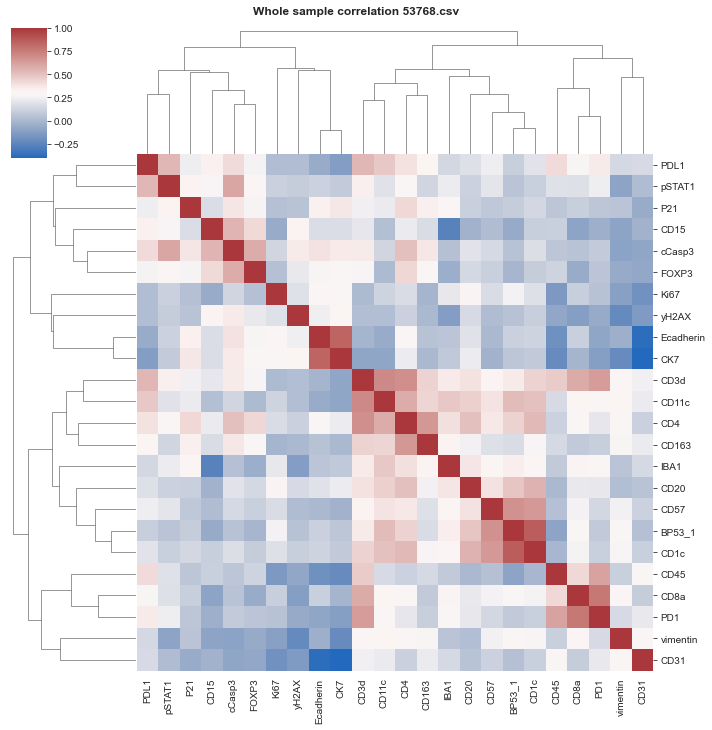

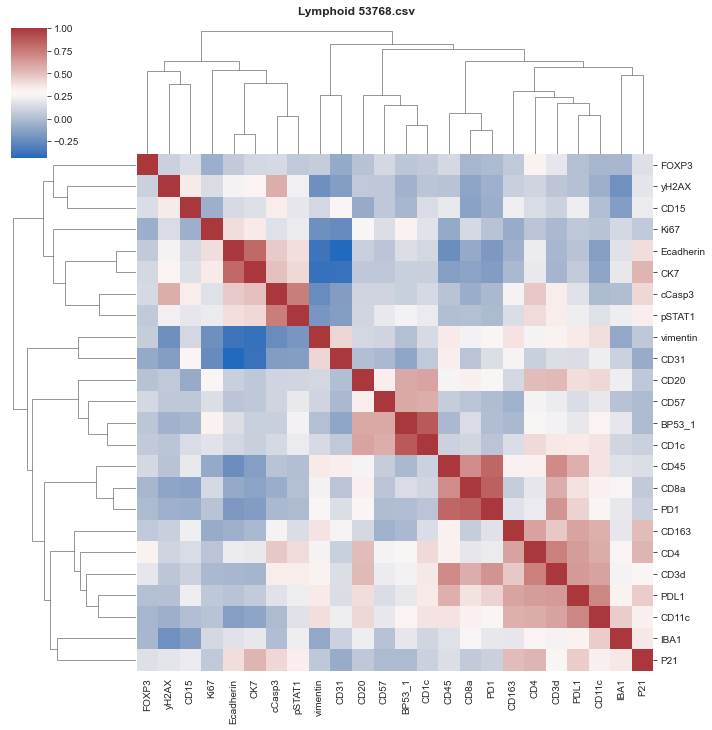

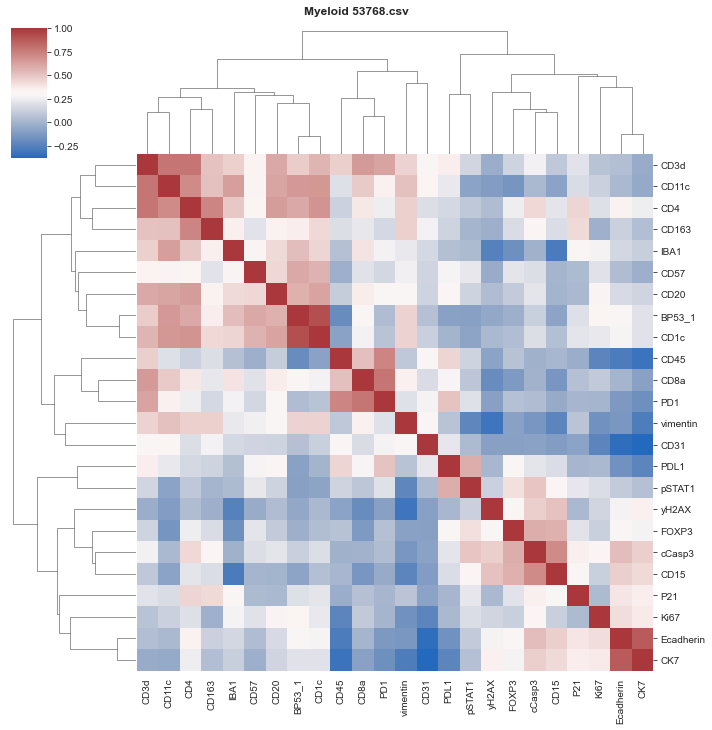

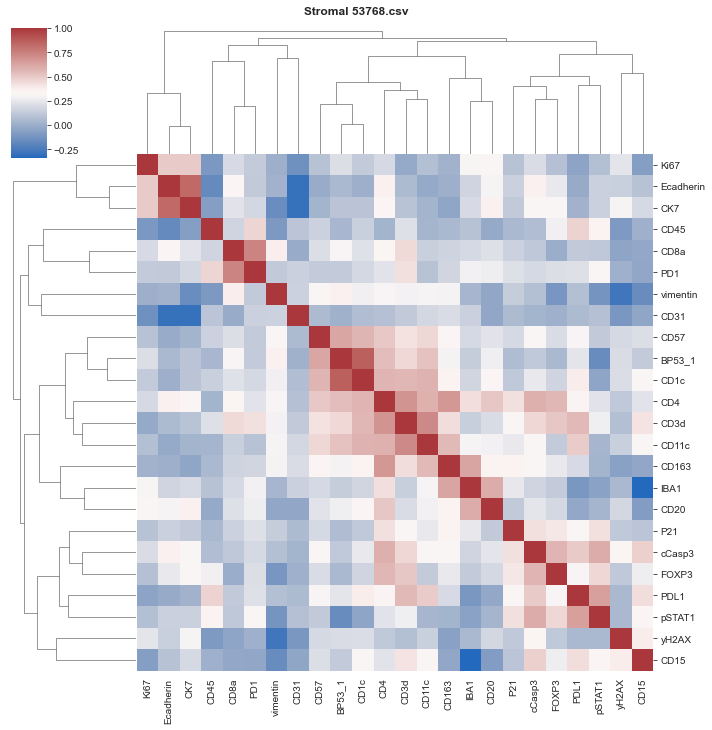

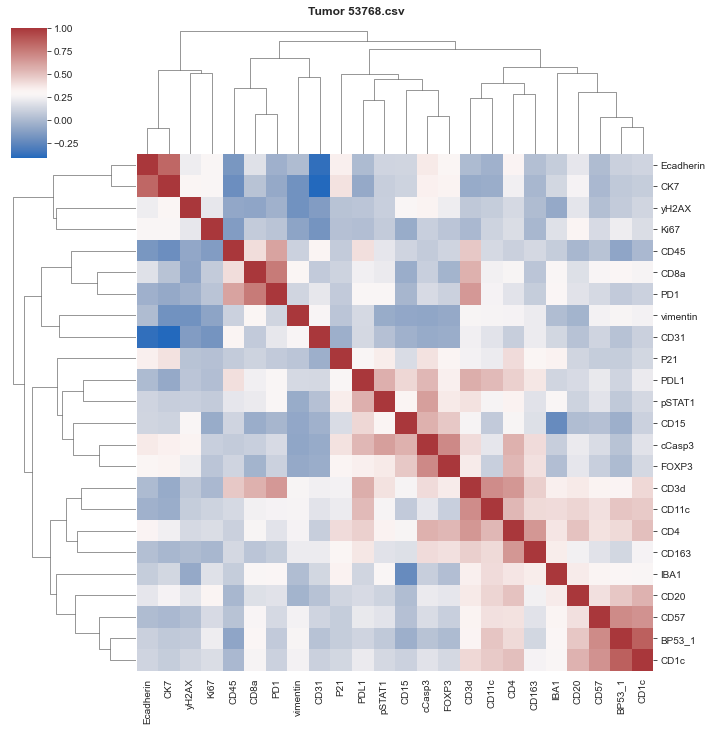

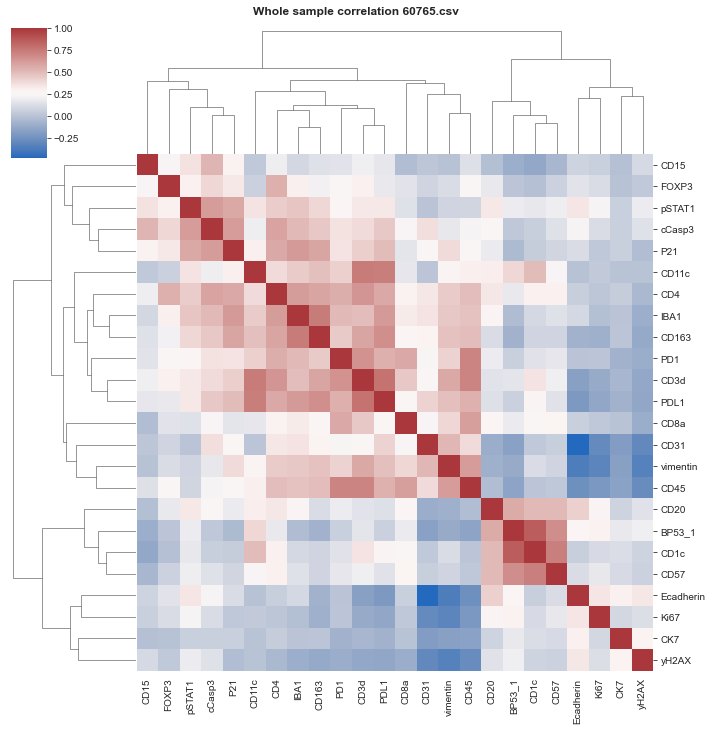

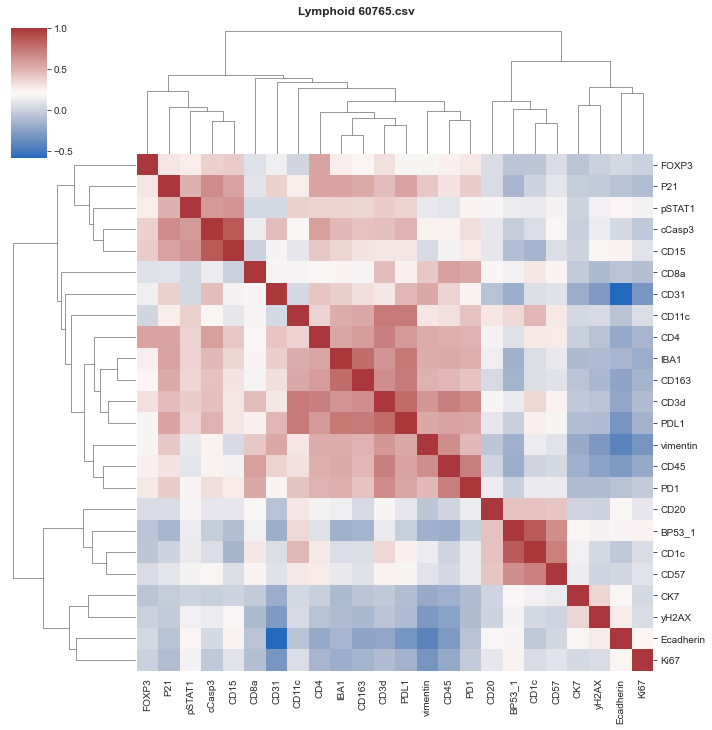

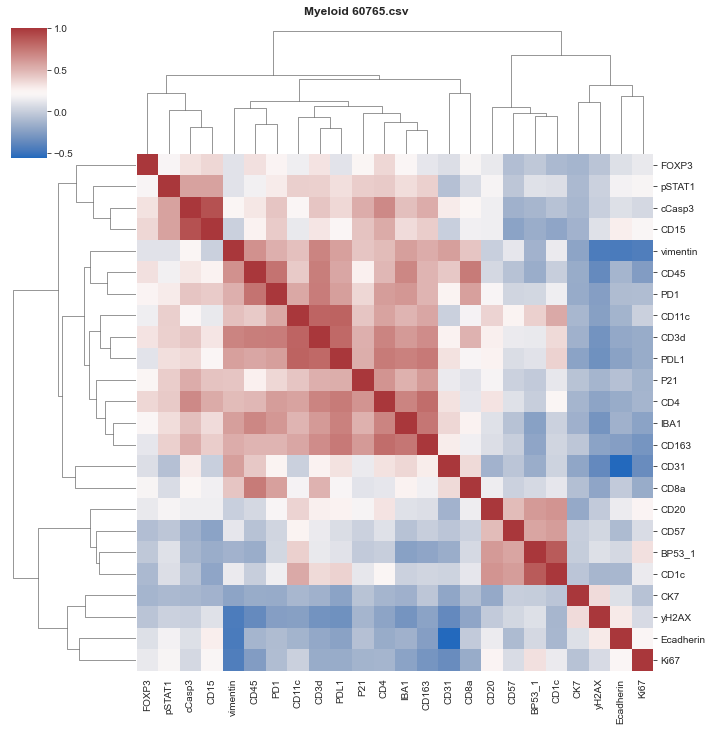

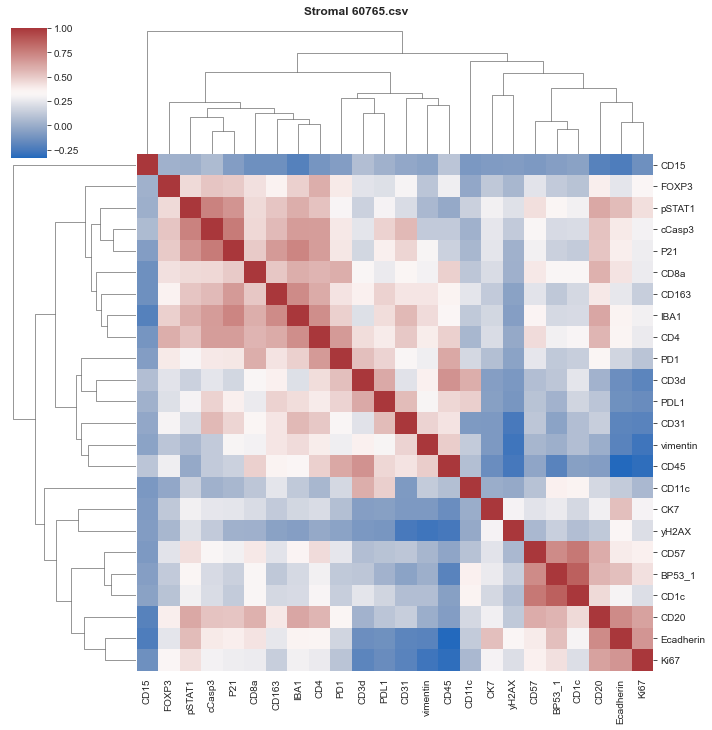

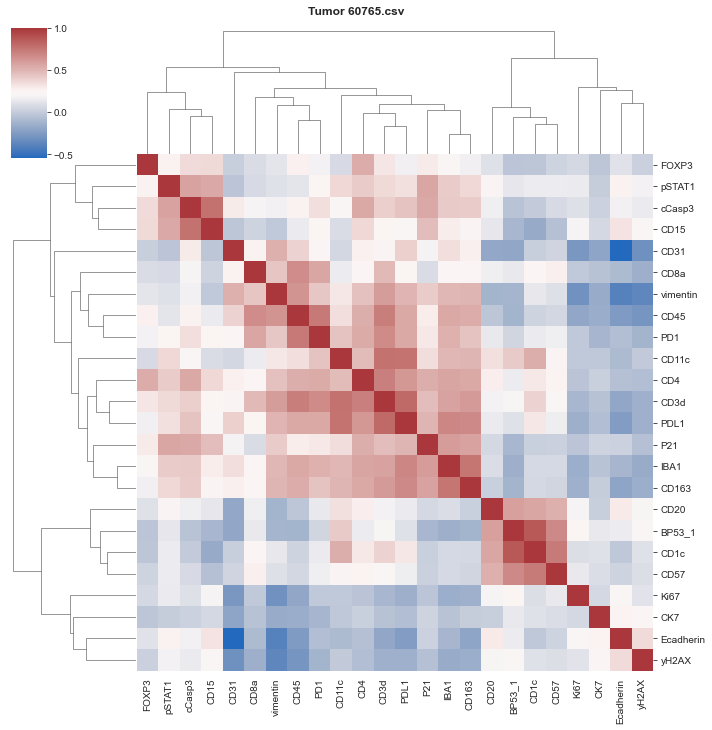

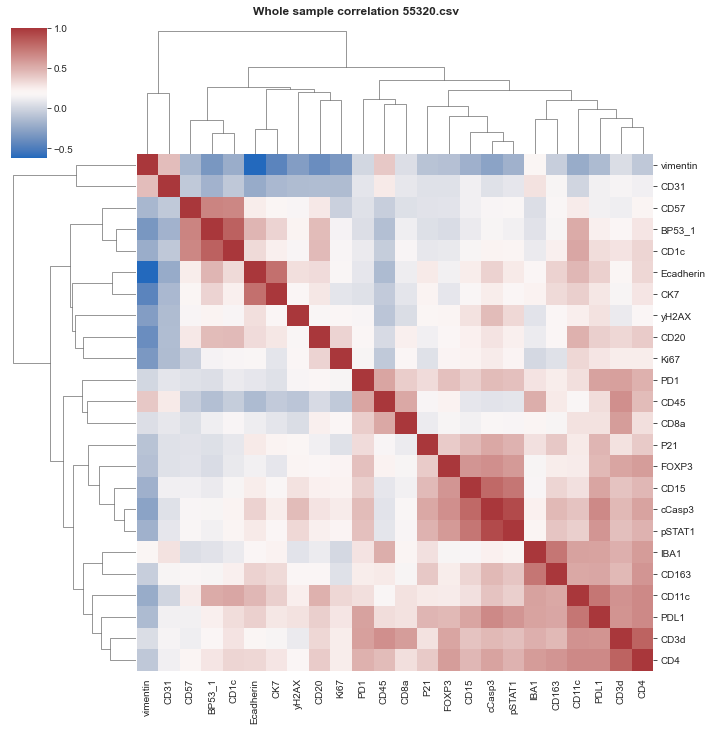

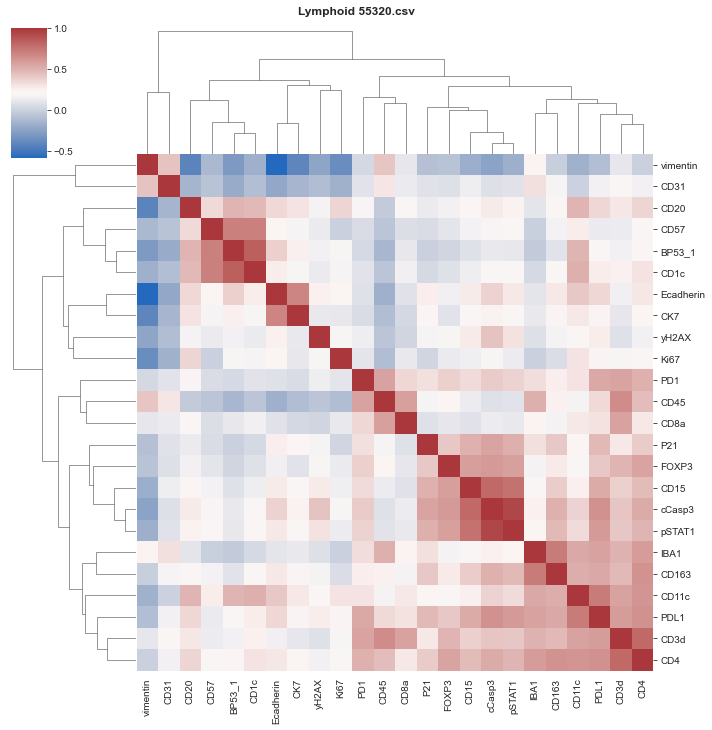

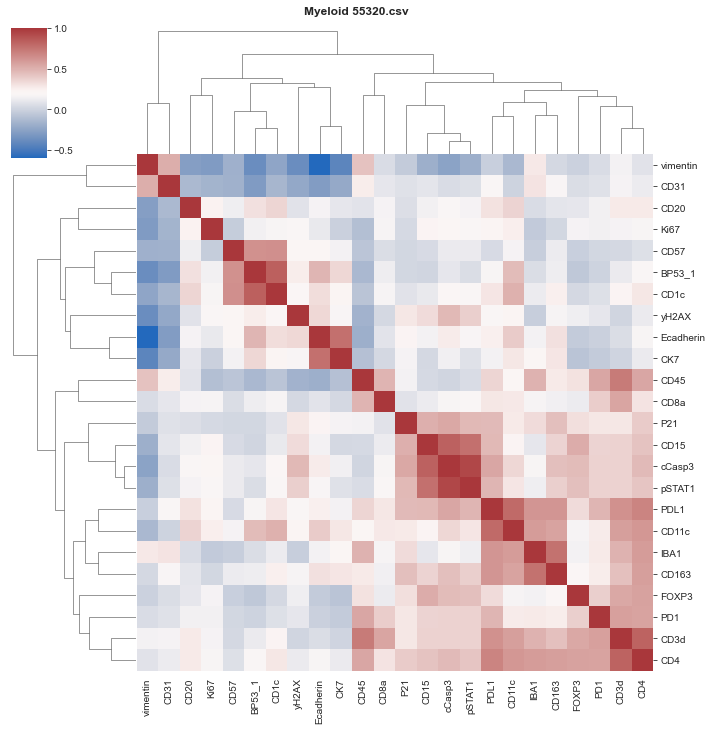

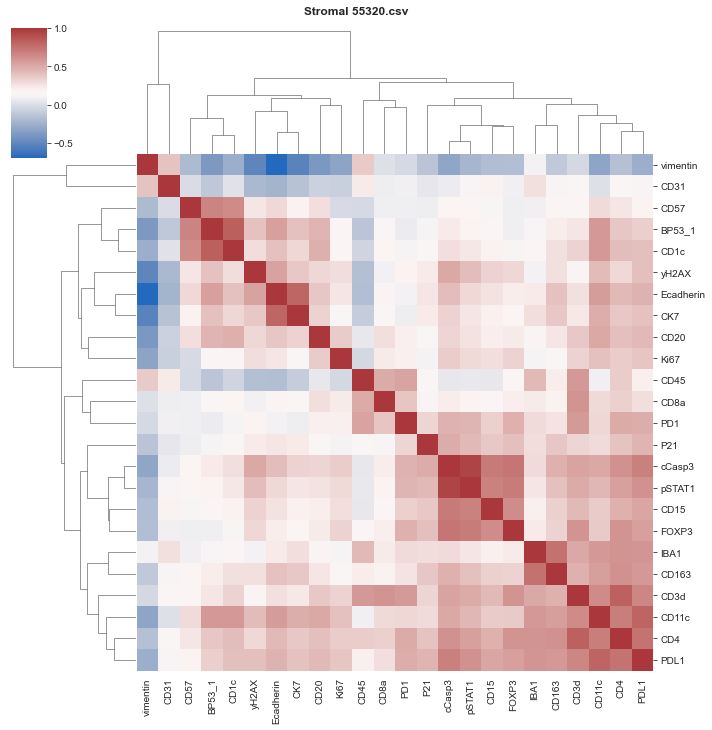

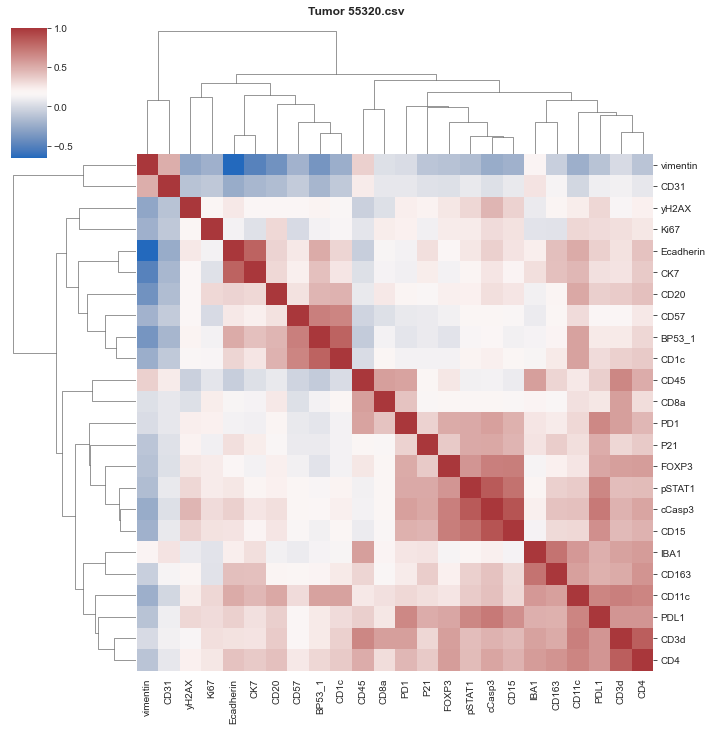

In [9]:
for i in range(nr_of_samples):
    vis_corr_mx_one_sample(all_samples[i], cell_type_subsets[i], all_markers, all_cell_types[i], samples[i])

## Heatmaps of marker expressions

In [10]:
def get_heatmap(tables, cell_types, sample_name):
    df_median = pd.DataFrame()
    for i in range(len(cell_types)):
        df_median[cell_types[i]] = tables[i].median()
    clustermap = sns.clustermap(df_median.transpose(), figsize=(10, 5), cmap='vlag').fig.suptitle(sample_name,fontweight="bold", y=1.01)

### Raw data

/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/3892174766.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_median[cell_types[i]] = tables[i].median()
/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/3892174766.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_median[cell_types[i]] = tables[i].median()
/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/3892174766.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_median[cell

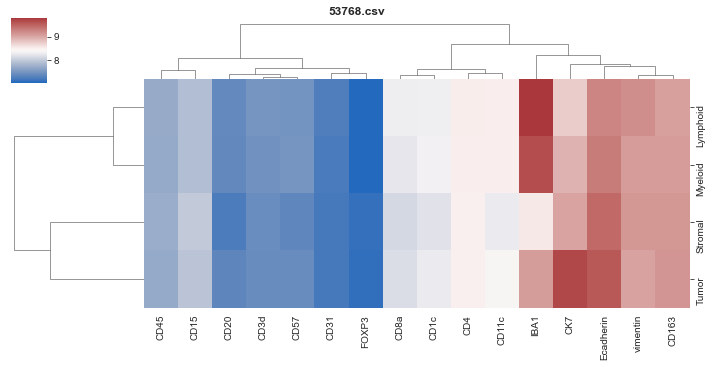

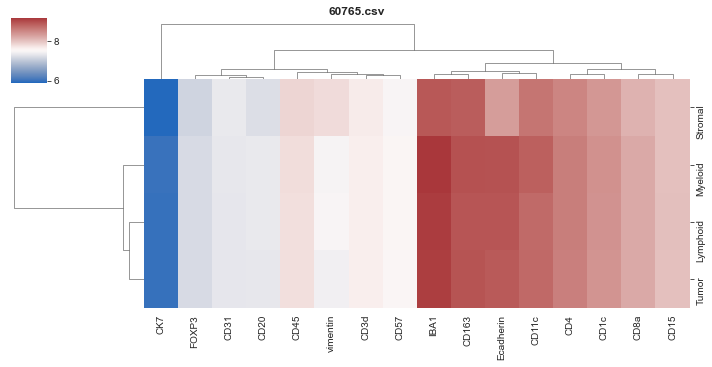

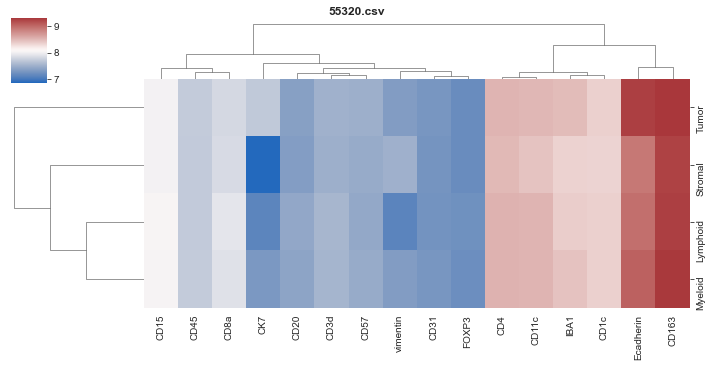

In [11]:
for i in range(nr_of_samples):
    get_heatmap(cell_type_subsets_filtered[i], all_cell_types[i], samples[i] )

### Z-score transformation

In [12]:
def z_score(df):
    z_scores = df.drop(['labels'], axis=1).apply(stats.zscore, axis = 1)
    z_scores['labels'] = df['labels']
    return z_scores

In [13]:
z_score_subsets = []
for i in range(nr_of_samples):
    subsets = []
    for subset in cell_type_subsets_filtered[i]:
        subsets.append(z_score(subset))
    z_score_subsets.append(subsets)

/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/3892174766.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_median[cell_types[i]] = tables[i].median()
/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/3892174766.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_median[cell_types[i]] = tables[i].median()
/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/3892174766.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_median[cell

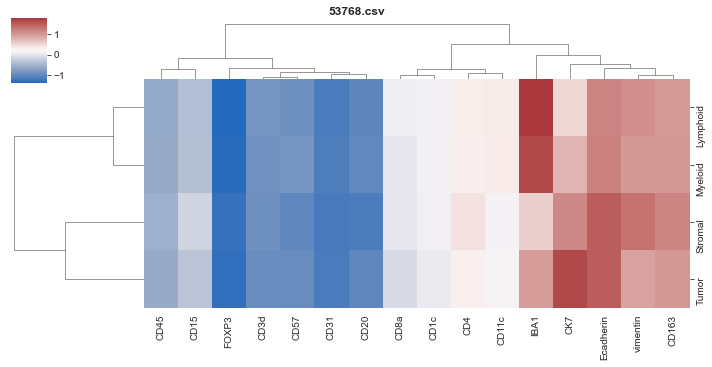

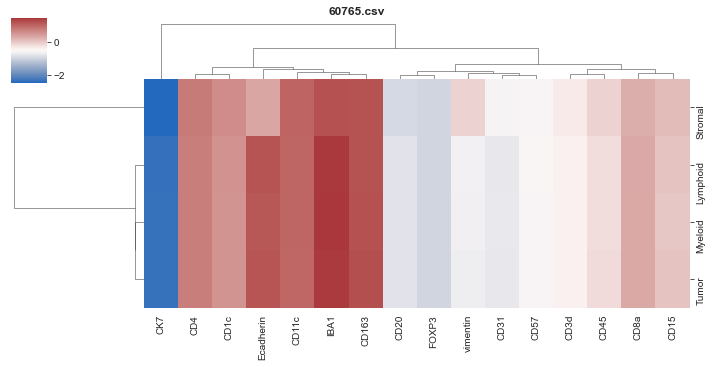

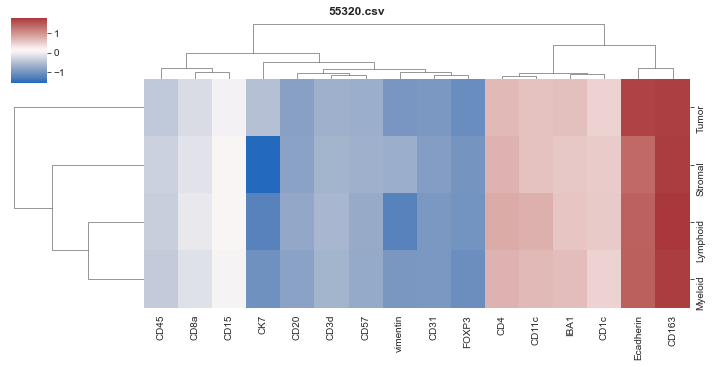

In [14]:
for i in range(nr_of_samples):
    get_heatmap(z_score_subsets[i], all_cell_types[i], samples[i] )

### 0-1 normalization

In [15]:
def zero_one(df):
    norm = df.drop(['labels'], axis = 1)
    norm = norm.div(norm.sum(axis=1), axis=0)
    norm['labels'] = df['labels']
    return norm

In [16]:
norm_subsets = []
for i in range(nr_of_samples):
    subsets = []
    for subset in cell_type_subsets_filtered[i]:
        subsets.append(zero_one(subset))
    norm_subsets.append(subsets)

/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/3892174766.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_median[cell_types[i]] = tables[i].median()
/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/3892174766.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_median[cell_types[i]] = tables[i].median()
/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/3892174766.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_median[cell

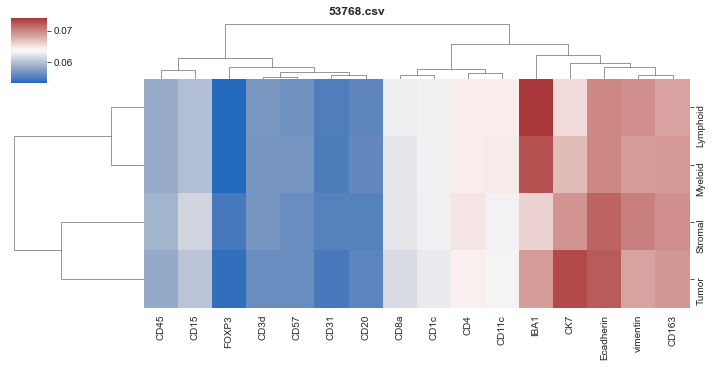

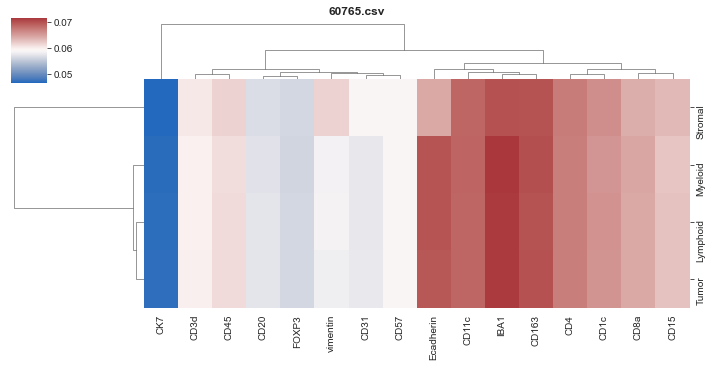

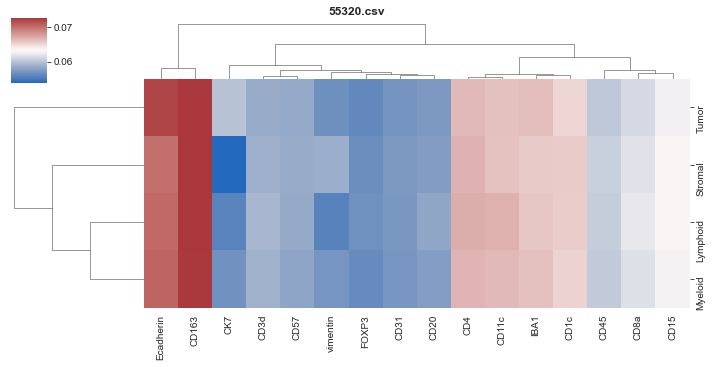

In [17]:
for i in range(nr_of_samples):
    get_heatmap(norm_subsets[i], all_cell_types[i], samples[i] )

### Standard scaler

In [18]:
def standard_scaler(df):
    table = df.drop(['labels'], axis = 1)
    standard = preprocessing.StandardScaler().fit_transform(table.transpose())
    res = pd.DataFrame(np.transpose(standard), columns= table.columns).set_index(table.index)
    res['labels'] = df['labels']
    return res

In [19]:
standard_subsets = []
for i in range(nr_of_samples):
    subsets = []
    for subset in cell_type_subsets_filtered[i]:
        subsets.append(standard_scaler(subset))
    standard_subsets.append(subsets)

/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/3892174766.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_median[cell_types[i]] = tables[i].median()
/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/3892174766.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_median[cell_types[i]] = tables[i].median()
/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/3892174766.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_median[cell

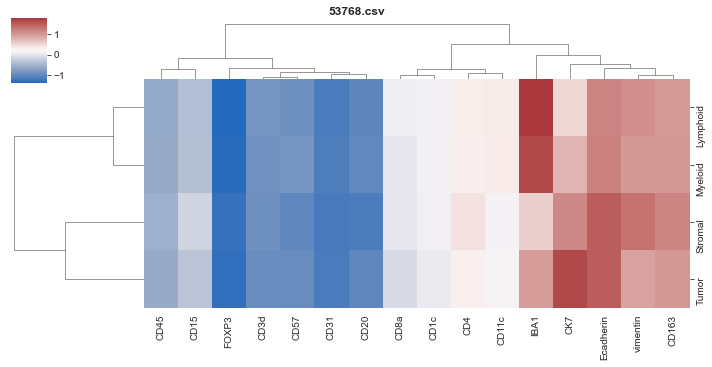

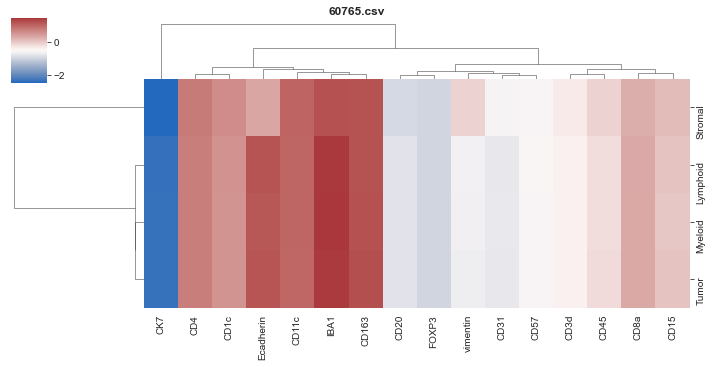

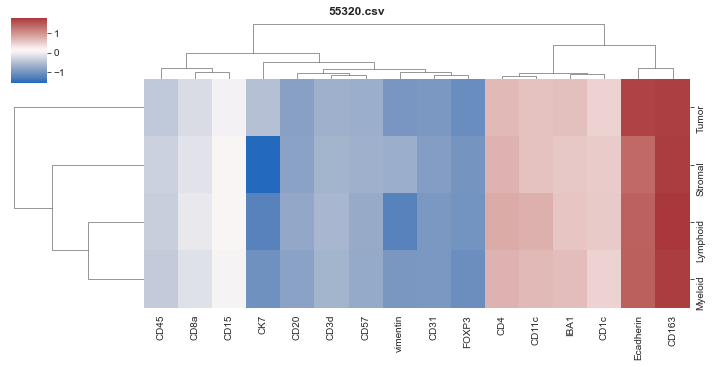

In [20]:
for i in range(nr_of_samples):
    get_heatmap(standard_subsets[i], all_cell_types[i], samples[i] )

### LogTransform

In [21]:
def log_transform(df):
    table = df.drop(['labels'], axis = 1)
    log = preprocessing.FunctionTransformer(np.log1p).fit_transform(table.transpose())
    res = pd.DataFrame(np.transpose(log), columns=table.columns).set_index(table.index)
    res['labels'] = df['labels']
    return res

In [22]:
log_subsets = []
for i in range(nr_of_samples):
    subsets = []
    for subset in cell_type_subsets_filtered[i]:
        subsets.append(log_transform(subset))
    log_subsets.append(subsets)

/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/3892174766.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_median[cell_types[i]] = tables[i].median()
/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/3892174766.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_median[cell_types[i]] = tables[i].median()
/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/3892174766.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_median[cell

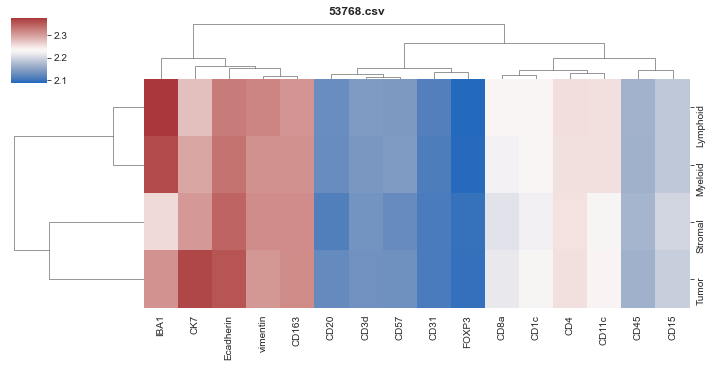

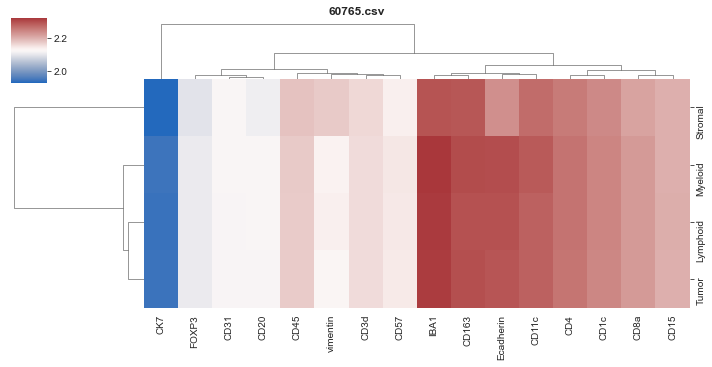

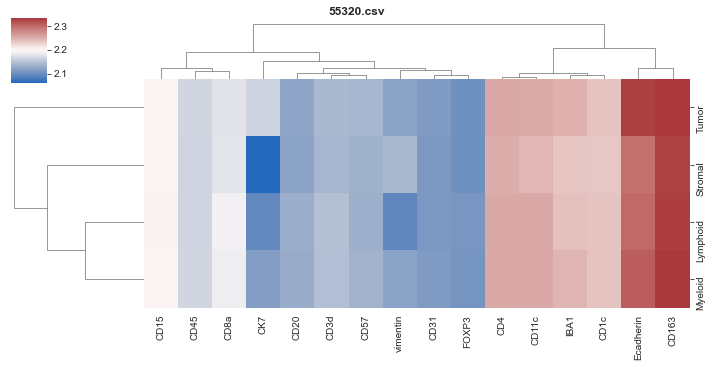

In [23]:
for i in range(nr_of_samples):
    get_heatmap(log_subsets[i], all_cell_types[i], samples[i] )

### LogTransfrom & StandardScaler

In [24]:
def log_standard(df):
    table = df.drop(['labels'], axis = 1)
    log = preprocessing.FunctionTransformer(np.log1p).fit_transform(table.transpose())
    log = preprocessing.StandardScaler().fit_transform(log)
    res = pd.DataFrame(np.transpose(log), columns=table.columns).set_index(table.index)
    res['labels'] = df['labels']
    return res

In [25]:
log_standard_subsets = []
for i in range(nr_of_samples):
    subsets = []
    for subset in cell_type_subsets_filtered[i]:
        subsets.append(log_standard(subset))
    log_standard_subsets.append(subsets)

/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/3892174766.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_median[cell_types[i]] = tables[i].median()
/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/3892174766.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_median[cell_types[i]] = tables[i].median()
/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/3892174766.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_median[cell

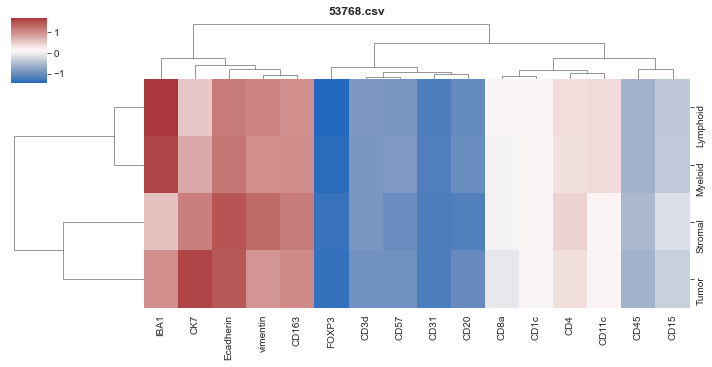

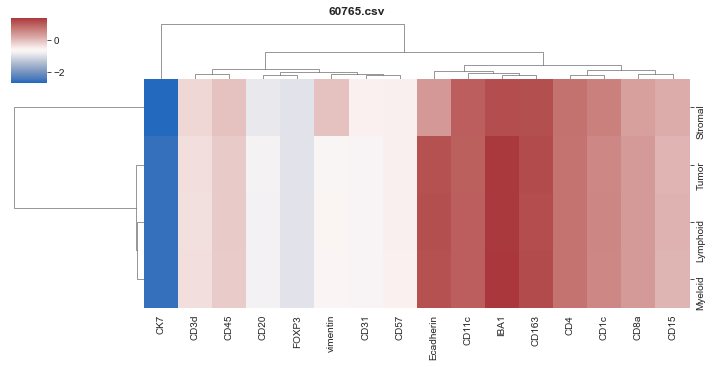

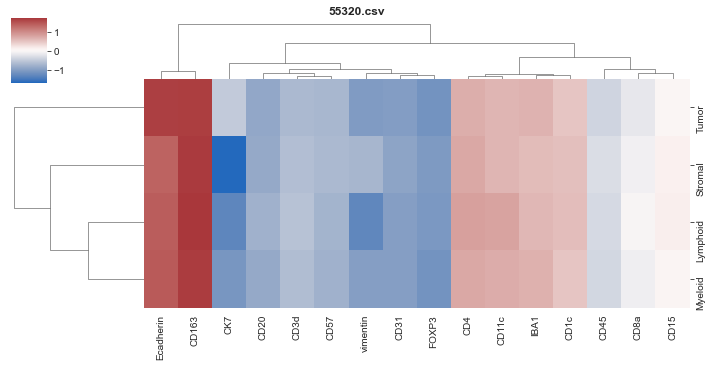

In [26]:
for i in range(nr_of_samples):
    get_heatmap(log_standard_subsets[i], all_cell_types[i], samples[i] )

## T-SNE/UMAP

In [27]:
def no_trans(table):
    return table

In [28]:
def do_tsne_labels(table, transformation, init, metric, n_iter, perplexity, learning_rate):
    markers = table.columns
    features = transformation(table)
    features = features.drop(['labels'], axis = 1)
    tsne = pd.DataFrame(
        data = TSNE(n_components = 2, init = init, metric = metric, n_iter= n_iter, perplexity= perplexity, learning_rate= learning_rate).fit_transform(features), columns = ["component 1", "component 2"])
    tsne['labels'] = table['labels']
    _, ax = plt.subplots(figsize = (16, 10))

    palette = sns.dark_palette("#FF0000", as_cmap=True)
    matplotlib.cm.register_cmap("mycolormap", palette)

    sns.scatterplot(data = tsne, x = "component 1", y = "component 2", ax = ax, alpha = 0.8, hue = 'labels', palette='mycolormap')

/Users/farateod/Documents/GitHub/tribus/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


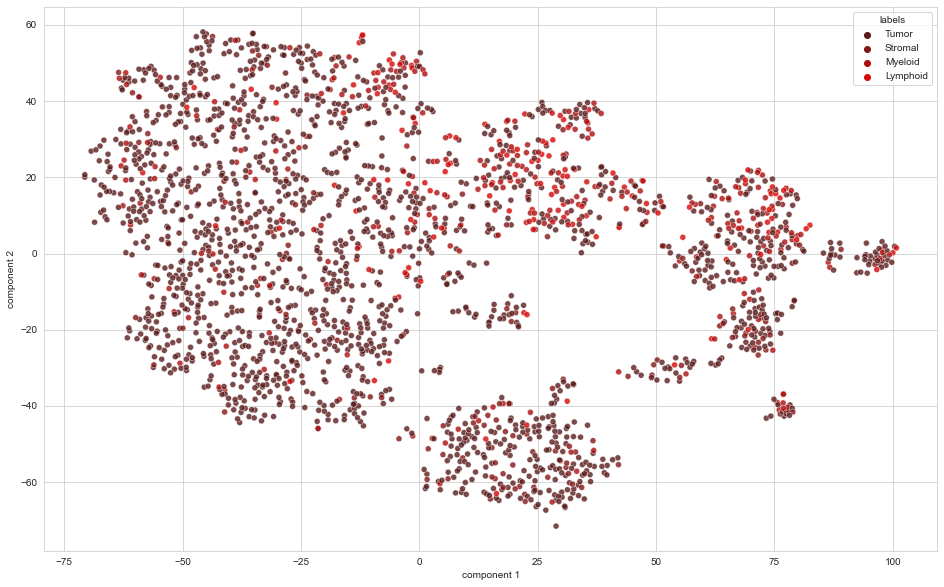

In [29]:
do_tsne_labels(filtered_samples[0], log_standard, 'pca', metric='euclidean',  n_iter= 10000, perplexity= 30, learning_rate= 160)

In [30]:
def do_tsne(table, transformation, init, metric, n_iter, perplexity, learning_rate):
    markers = table.columns
    features = transformation(table)
    features = features.drop(['labels'], axis = 1)
    tsne = pd.DataFrame(
        data = TSNE(n_components = 2, init = init, metric = metric, n_iter= n_iter, perplexity= perplexity, learning_rate= learning_rate).fit_transform(features), columns = ["component 1", "component 2"])

    columns = math.ceil(len(markers)/3)
    _, ax = plt.subplots(3, columns, figsize = (22, 16))

    palette = sns.dark_palette("#FF0000", as_cmap=True)
    matplotlib.cm.register_cmap("mycolormap", palette)

    for i in range(len(markers)):
        tsne[markers[i]] = table[markers[i]]
        sns.scatterplot(data = tsne, x = "component 1", y = "component 2", ax = ax[int(i/columns)][i%columns], alpha = 0.8, hue = markers[i], palette='mycolormap')

/Users/farateod/Documents/GitHub/tribus/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/1345424014.py:12: UserWarning: Trying to register the cmap 'mycolormap' which already exists.
  matplotlib.cm.register_cmap("mycolormap", palette)


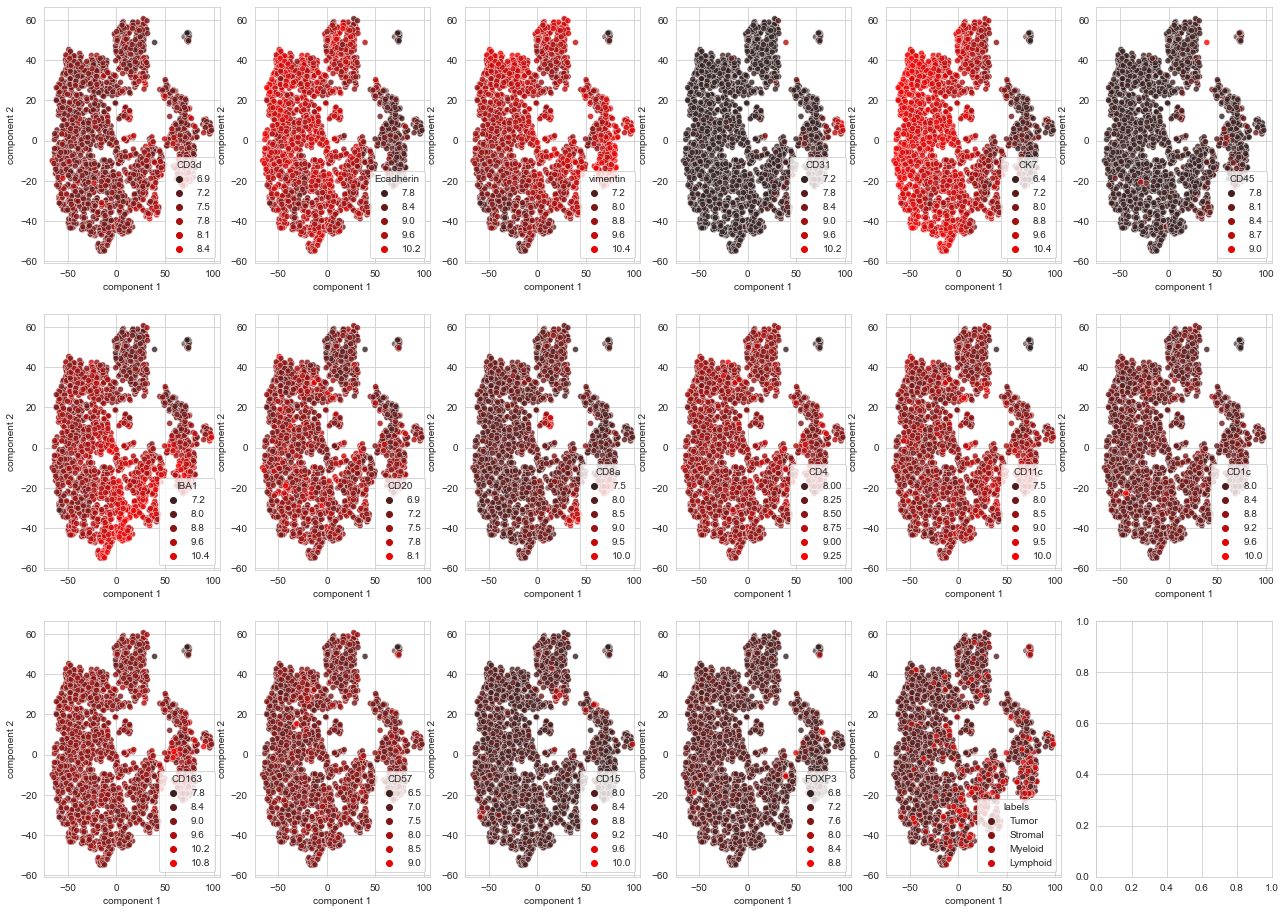

In [31]:
do_tsne(filtered_samples[0], no_trans, 'pca', metric='cosine',  n_iter= 10000, perplexity= 25, learning_rate= 450)

## UMAP

In [32]:
def do_umap_labels(table, transformation, n_components=2, init='spectral', random_state=0, n_neighbors=10, min_dist=0.1, metric='correlation'):
    markers = table.columns
    features = transformation(table)
    features = features.drop(['labels'], axis = 1)

    proj_2d = pd.DataFrame(data = UMAP(n_components=n_components, init=init, random_state=random_state, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric).fit_transform(features), columns = ["component 1", "component 2"])

    palette = sns.dark_palette("#FF0000", as_cmap=True)
    matplotlib.cm.register_cmap("mycolormap", palette)

    proj_2d['labels'] = table['labels']
    _, ax = plt.subplots(figsize = (16, 10))
    sns.scatterplot(data = proj_2d, x = "component 1", y = "component 2", ax = ax, alpha = 0.8, hue = 'labels', palette = 'mycolormap')

/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/850290458.py:9: UserWarning: Trying to register the cmap 'mycolormap' which already exists.
  matplotlib.cm.register_cmap("mycolormap", palette)


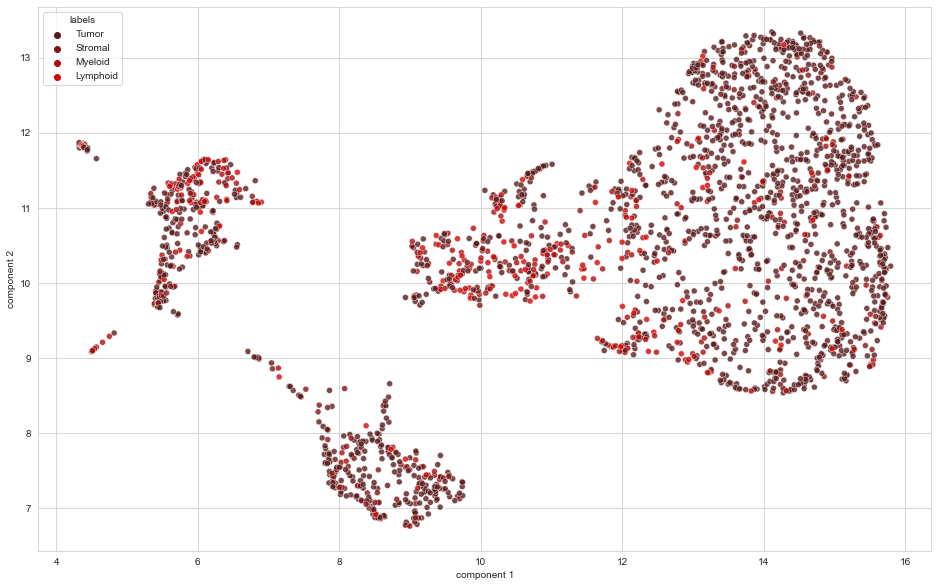

In [33]:
do_umap_labels(filtered_samples[0], log_standard, n_components=2, init='spectral', random_state=0, n_neighbors=100, min_dist=0.0, metric='correlation')

In [34]:
def do_umap(table, transformation, n_components=2, init='spectral', random_state=0, n_neighbors=10, min_dist=0.1, metric='correlation'):
    markers = table.columns
    features = transformation(table)
    features = features.drop(['labels'], axis = 1)

    proj_2d = pd.DataFrame(data = UMAP(n_components=n_components, init=init, random_state=random_state, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric).fit_transform(features), columns = ["component 1", "component 2"])
    columns = math.ceil(len(markers)/3)
    _, ax = plt.subplots(3, columns, figsize = (22, 16))
    palette = sns.dark_palette("#FF0000", as_cmap=True)
    matplotlib.cm.register_cmap("mycolormap", palette)

    for i in range(len(markers)):

        proj_2d[markers[i]] = table[markers[i]]

        sns.scatterplot(data = proj_2d, x = "component 1", y = "component 2", ax = ax[int(i/columns)][i%columns], alpha = 0.8, hue = markers[i], palette = 'mycolormap' )

/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/1049945403.py:10: UserWarning: Trying to register the cmap 'mycolormap' which already exists.
  matplotlib.cm.register_cmap("mycolormap", palette)


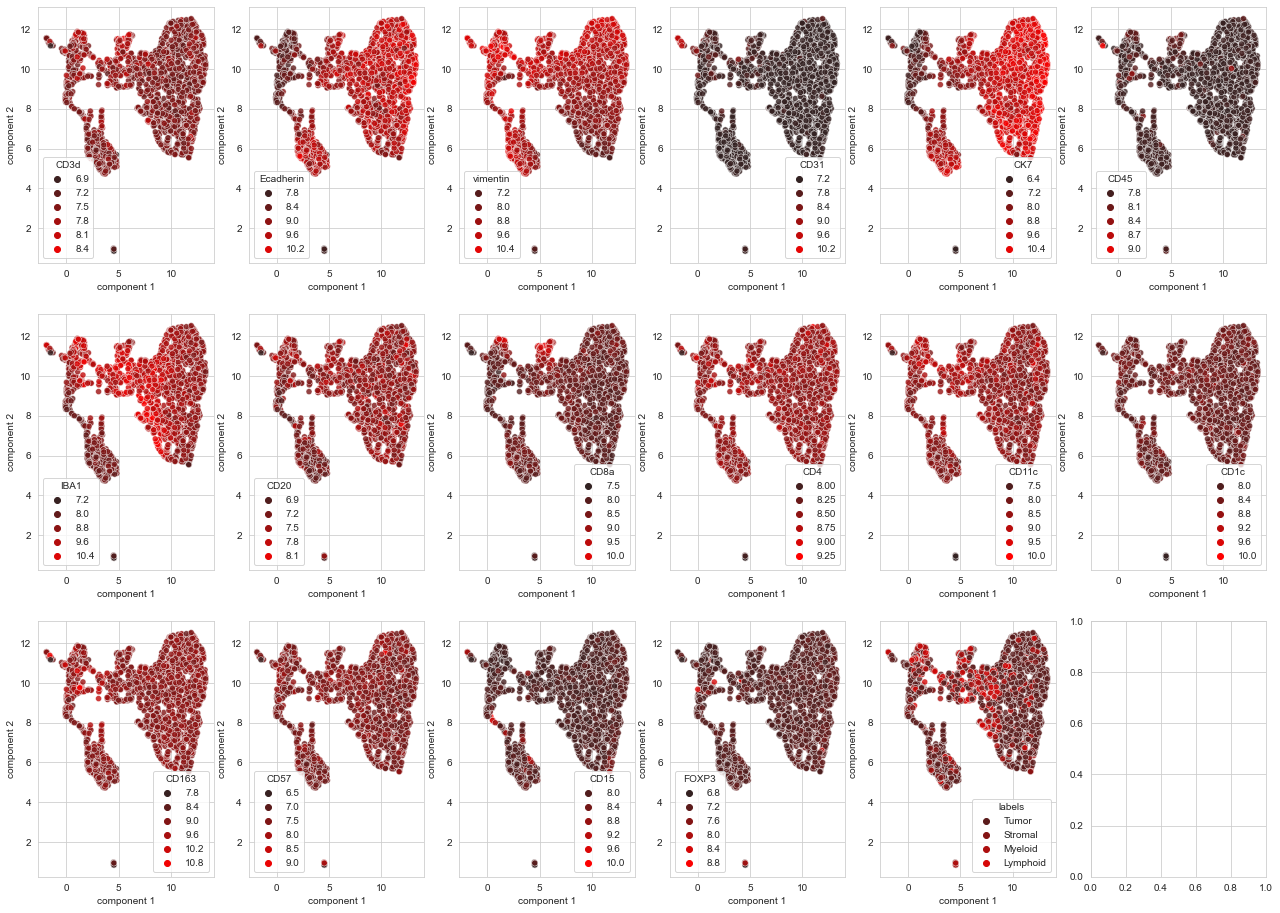

In [35]:
do_umap(filtered_samples[0], log_transform)

/var/folders/s7/3cx0kcnx1l3c0q3j3zflxh2d4wdlm2/T/ipykernel_50113/1049945403.py:10: UserWarning: Trying to register the cmap 'mycolormap' which already exists.
  matplotlib.cm.register_cmap("mycolormap", palette)


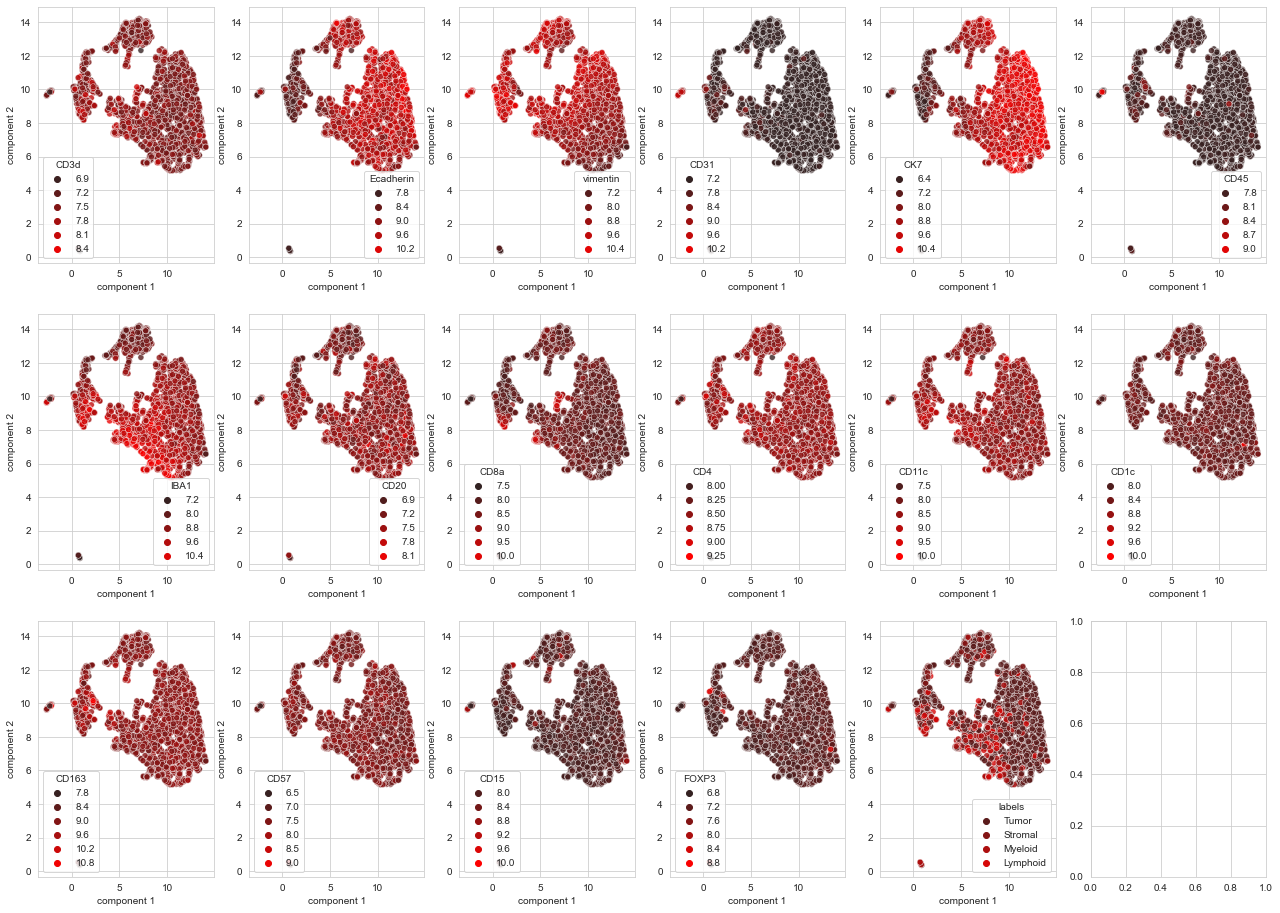

In [36]:
do_umap(filtered_samples[0], no_trans)